In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import cm
import os
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import pickle
from wordcloud import WordCloud
sns.set()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zeming/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/zeming/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zeming/nltk_data...


In [2]:
english = stopwords.words('english') # For US, CA, and GB videos
counter = 0
for words in english:
    print(words)
    counter = counter + 1
    if counter > 10:
        break

i
me
my
myself
we
our
ours
ourselves
you
you're
you've


In [3]:
german = stopwords.words('german') # DE videos
french = stopwords.words('french') # FR videos
english.extend(german) # adding stopwords from german to english list
english.extend(french) # adding stopwords from french to english list
stopwords_list = [] # one huge combined list of stop words from different languages
for words in english:
    stopwords_list.append(words)

In [5]:
GBvideos = pd.read_csv('./data/GBvideos.csv')
GB_videos_categories = pd.read_json('./data/GB_category_id.json')

In [6]:
import json
f = open("./data/GB_category_id.json")
data = f.read()
f.close()
out = json.loads(data)
categories = pd.DataFrame([
    {'category_id':x['id'],
     'category':x['snippet']['title'],
     'assignable':x['snippet']['assignable']
    } for x in out['items']
])
categories['category_id'] = categories['category_id'].astype(int)

GBvideos['category_id'] = GBvideos['category_id'].astype(int)
GBvideos = GBvideos.merge(categories, on='category_id')
GBvideos.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'category', 'assignable'],
      dtype='object')

In [15]:
def extract_tags(category):
    temp = GBvideos[GBvideos['category'] == category]
    tags = []
    for t in temp['tags']:
        tags.append(t)
    return tags

In [33]:
import re
def clean_tags(tags):
    output = []
    for i in range(len(tags)):
        tags[i] = tags[i].lower()
        tags[i] = re.sub('[^A-Za-z]+', ' ', tags[i]) # to remove punctuation if any 
        tags[i] = tags[i].strip()
        tags[i] = word_tokenize(tags[i]) # it just splits words into individual words
        tags[i] = [w for w in tags[i] if not w in stopwords_list] # removing stopwords
        tags[i] = [word for word in tags[i] if len(word) > 2]  # removing any word whose length is 1 or 2
        tags[i] = [word for word in tags[i] if not word.isdigit()] # removing numerics
        for w in tags[i]:
            output.append(w)
    return output

In [34]:
GB_videos_categories = pd.read_json('./data/GB_category_id.json')

# Map Category IDs using the supporting file: US_category_id.json
categories = [category['snippet']['title'] for category in GB_videos_categories['items']]

['Film & Animation',
 'Autos & Vehicles',
 'Music',
 'Pets & Animals',
 'Sports',
 'Short Movies',
 'Travel & Events',
 'Gaming',
 'Videoblogging',
 'People & Blogs',
 'Comedy',
 'Entertainment',
 'News & Politics',
 'Howto & Style',
 'Education',
 'Science & Technology',
 'Movies',
 'Anime/Animation',
 'Action/Adventure',
 'Classics',
 'Comedy',
 'Documentary',
 'Drama',
 'Family',
 'Foreign',
 'Horror',
 'Sci-Fi/Fantasy',
 'Thriller',
 'Shorts',
 'Shows',
 'Trailers']

In [35]:
all = [] # contains final cleaned tags from every individual category
for c in categories:
    tags = extract_tags(c)
    cleaned = clean_tags(tags)
    all.append(cleaned)

In [36]:
def get_polarities(tags):
    max = 2000 # 2000 words to be taken from each category tags
    frequency = nltk.FreqDist(tags) # calculating frequency of each word
    temp = pd.DataFrame(frequency.most_common(max),
                    columns=['Word', 'Frequency'])
    compound = .0 # polarity is initially 0.0
    polarities = []
    for word in temp['Word'].head(max):
        compound += SentimentIntensityAnalyzer().polarity_scores(word)['compound']
        
    return compound

In [37]:
polarities = [] # list of polarities from tags of individual categories
for a in all:
    polarity = get_polarities(a)
    polarities.append(polarity)

polarities

[-13.423999999999998,
 0.6978,
 8.343600000000011,
 11.601899999999995,
 5.081000000000005,
 0.0,
 0.7586999999999999,
 2.4818000000000002,
 0.0,
 21.5796,
 6.226200000000004,
 10.233399999999998,
 -2.1875,
 18.775300000000005,
 6.991400000000002,
 4.297499999999999,
 0.0,
 0.0,
 0.0,
 0.0,
 6.226200000000004,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3612,
 0.0]

Text(0.5, 1.0, 'Sentiment Analysis')

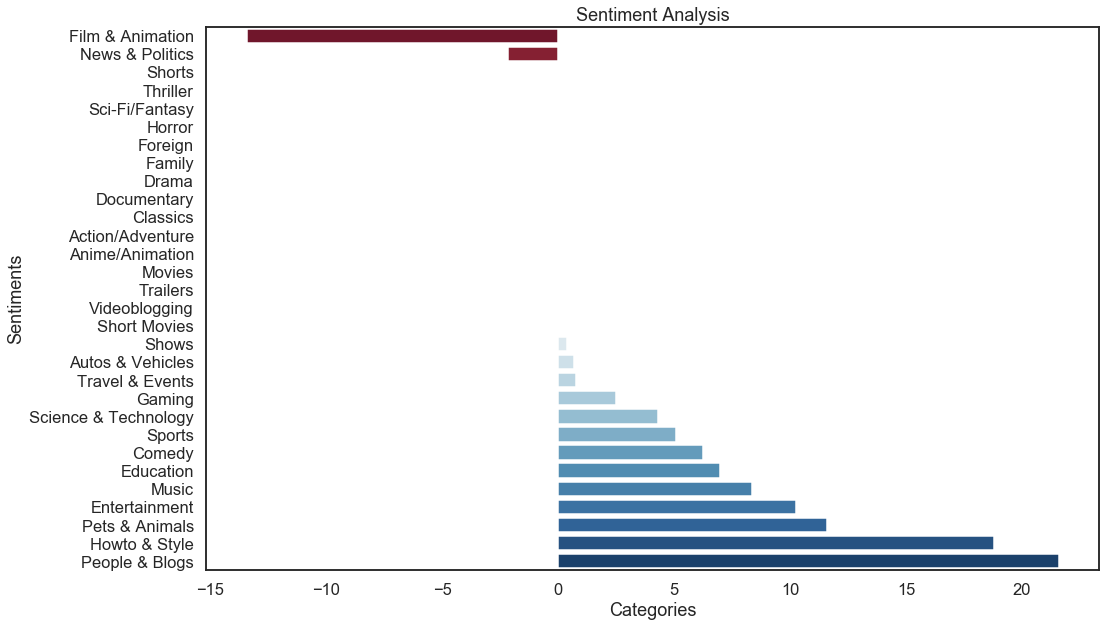

In [38]:
categories = pd.DataFrame(categories)
polarities = pd.DataFrame(polarities)
sentiments = pd.concat([categories, polarities], axis=1)
sentiments.columns = ['category', 'polarity']
sentiments = sentiments.sort_values('polarity').reset_index()
fig = plt.figure(figsize=(16, 10))
sns.set(style="white", context="talk")
ax = sns.barplot(x=sentiments['polarity'], y=sentiments['category'], data=sentiments,orient='h',palette="RdBu")
plt.xlabel("Categories")
plt.ylabel("Sentiments")
plt.title("Sentiment Analysis")

In [39]:
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
import random
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [41]:
cwd = os.getcwd()
random.seed( 30 )
y = GBvideos.views
x_train, x_test, y_train, y_test = train_test_split(GBvideos, y, test_size=0.2)

In [42]:
predictors = ["likes","dislikes"]
x_train = x_train[predictors]
x_test = x_test[predictors]

In [43]:
lm = linear_model.LinearRegression()
model = lm.fit(x_train, y_train)
predictions = lm.predict(x_test)
# To retrieve the intercept
print(lm.intercept_)
# For retrieving the slope
print('regressor coffecient:',lm.coef_)

127352.68755851965
regressor coffecient: [41.88157339 19.7330237 ]


In [45]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
df1 = df.head(30)

import plotly.figure_factory as ff
hist_data = [df.Actual, df.Predicted]
group_labels = ['Actual', 'Predicted']

fig = ff.create_distplot(hist_data, group_labels, bin_size=.2)
fig.show()

In [ ]:
pd.qcut()